In [171]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from keras.layers import Dense, Input
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

**Data PreProcessing**

In [62]:
df=pd.DataFrame(pd.read_excel("customer_churn_large_dataset.xlsx"))

In [63]:
df.head()

,CustomerID,Name,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
0,1,Customer_1,63,Male,Los Angeles,17,73.36,236,0
1,2,Customer_2,62,Female,New York,1,48.76,172,0
2,3,Customer_3,24,Female,Los Angeles,5,85.47,460,0
3,4,Customer_4,36,Female,Miami,3,97.94,297,1
4,5,Customer_5,46,Female,Miami,19,58.14,266,0


Checking if there are any null values

In [64]:
df.isnull().sum()

CustomerID                    0
Name                          0
Age                           0
Gender                        0
Location                      0
Subscription_Length_Months    0
Monthly_Bill                  0
Total_Usage_GB                0
Churn                         0
dtype: int64

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   CustomerID                  100000 non-null  int64  
 1   Name                        100000 non-null  object 
 2   Age                         100000 non-null  int64  
 3   Gender                      100000 non-null  object 
 4   Location                    100000 non-null  object 
 5   Subscription_Length_Months  100000 non-null  int64  
 6   Monthly_Bill                100000 non-null  float64
 7   Total_Usage_GB              100000 non-null  int64  
 8   Churn                       100000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 6.9+ MB


Setting "Customer id" column to index as it is of no use

In [66]:
df=df.set_index('CustomerID')

Function to find Outliers

In [67]:
def find_outliers(data):
    # Calculate the first quartile (Q1) and third quartile (Q3)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)

    # Calculate the interquartile range (IQR)
    iqr = q3 - q1

    # Calculate the lower and upper bounds for outliers
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Find outliers
    outliers = [x for x in data if x < lower_bound or x > upper_bound]

    return outliers

In [68]:
x=['Age','Subscription_Length_Months','Monthly_Bill','Total_Usage_GB']

In [69]:
for i in x:
    if find_outliers(df[i])==[] :
        print(f'No Outliers Found in {i}')
    else :
        print('Outliers Found')

No Outliers Found in Age
No Outliers Found in Subscription_Length_Months
No Outliers Found in Monthly_Bill
No Outliers Found in Total_Usage_GB


Since there are no ouliers in the entire dataset we can move further in preprocessing

As we can see in the dataframe that the "Name" column don't carry much predictive power so we can exclude this column from the features used in modeling.

But Before that we have to check if there are 1,00,000 customers in the "Name" column because if not we might have to remove some rows before Excluding the "Name" column

In [71]:
# Extract numerical values from CustomerID column and counting them
df['Name'].str.split('_').str[1].astype(int).nunique()

100000

As we can see there are 1,00,000 customer names so it is safe to now Exclude the Name column since it is of no use for us in predicting

In [72]:
df.head()

,Name,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
CustomerID,,,,,,,,
1,Customer_1,63,Male,Los Angeles,17,73.36,236,0
2,Customer_2,62,Female,New York,1,48.76,172,0
3,Customer_3,24,Female,Los Angeles,5,85.47,460,0
4,Customer_4,36,Female,Miami,3,97.94,297,1
5,Customer_5,46,Female,Miami,19,58.14,266,0


In [73]:
df.columns

Index(['Name', 'Age', 'Gender', 'Location', 'Subscription_Length_Months',
       'Monthly_Bill', 'Total_Usage_GB', 'Churn'],
      dtype='object')

In [74]:
encoded_data = pd.get_dummies(df, columns=['Gender', 'Location'], drop_first=True)


In [76]:
encoded_data.head()

,Name,Age,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn,Gender_Male,Location_Houston,Location_Los Angeles,Location_Miami,Location_New York
CustomerID,,,,,,,,,,,
1,Customer_1,63,17,73.36,236,0,1,0,1,0,0
2,Customer_2,62,1,48.76,172,0,0,0,0,0,1
3,Customer_3,24,5,85.47,460,0,0,0,1,0,0
4,Customer_4,36,3,97.94,297,1,0,0,0,1,0
5,Customer_5,46,19,58.14,266,0,0,0,0,1,0


**Data Visualization**

<ipython-input-78-1cf18f0c0a7e>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = encoded_data.corr()


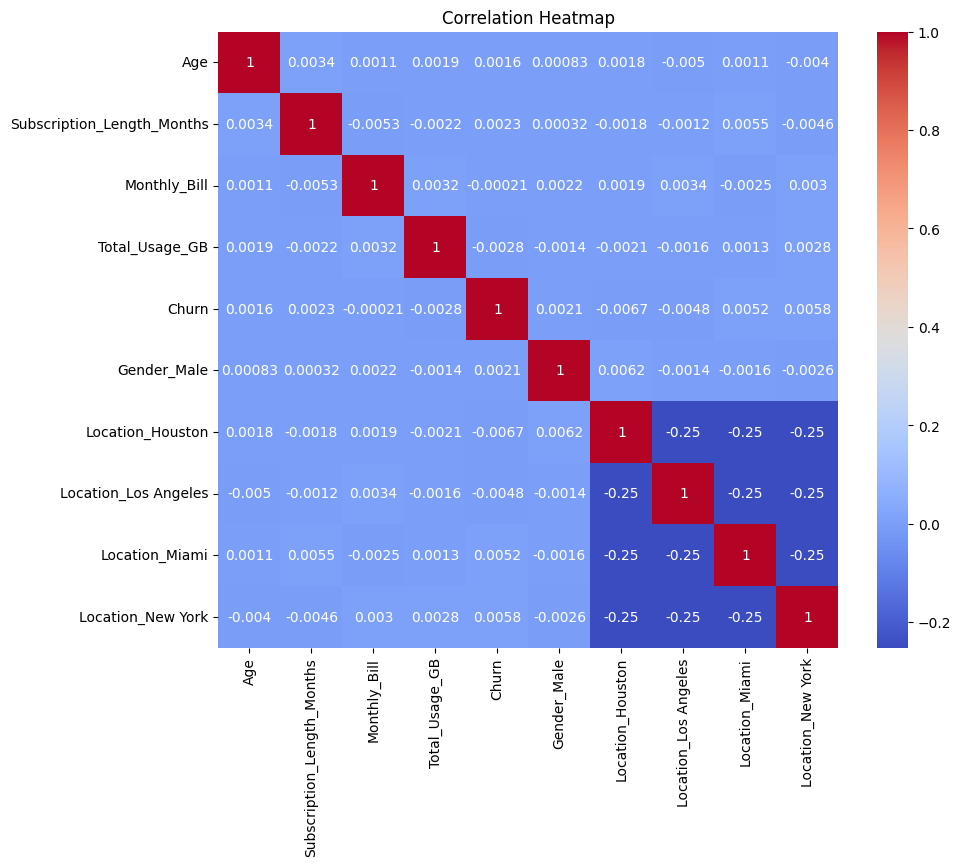

In [78]:
correlation_matrix = encoded_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

*   There is a strong positive correlation between “Subscription Length” and “Total Usage”, indicating that customers who have been subscribed for a longer period of time tend to use more data.
*   There is also a strong positive correlation between “Monthly Usage” and “Total Usage”, indicating that customers who use more data on a monthly basis also tend to have a higher total usage.
*   The highest negative correlations are between “Gender” and “Los Angeles”, “Miami” and “New York”, and “Los Angeles” and another variable. These negative correlations suggest that there may be some relationship between these variables, but further analysis would be needed to determine the nature of this relationship.






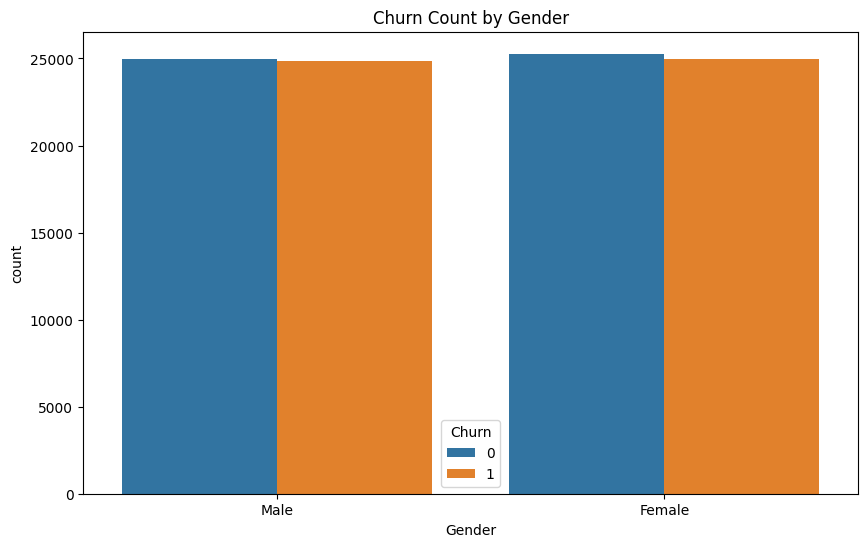

In [81]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Gender', hue='Churn', data=df)
plt.title('Churn Count by Gender')
plt.show()

The bars for males and females are approximately equal in height, indicating that the number of people who churned and did not churn is similar for both genders. This suggests that gender may not be a strong predictor of churn in this dataset.

<ipython-input-87-8fb6bea1af79>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Location', y='Total_Usage_GB', data=df, ci=None)


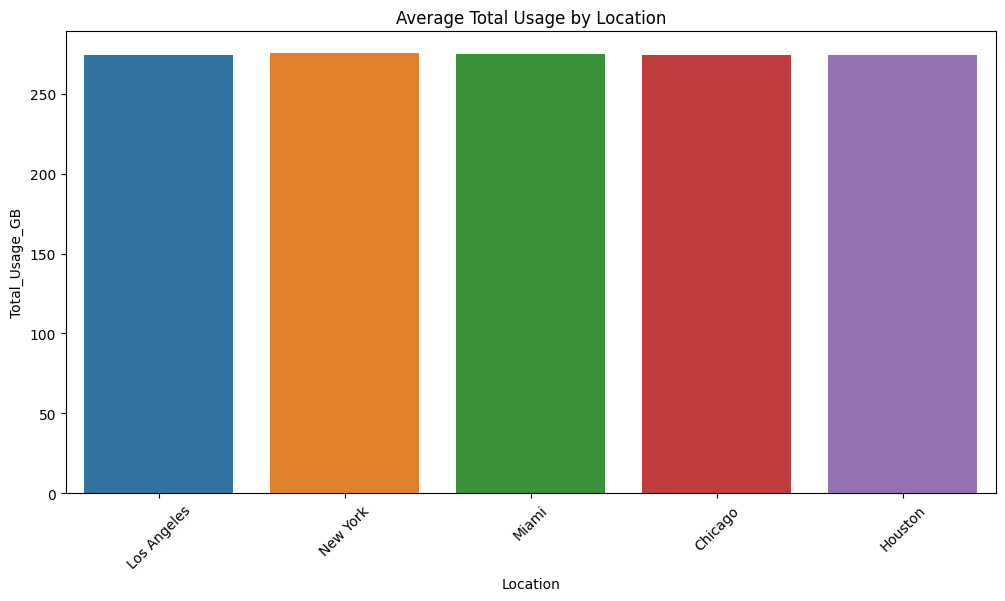

In [87]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Location', y='Total_Usage_GB', data=df, ci=None)
plt.xticks(rotation=45)
plt.title('Average Total Usage by Location')
plt.show()

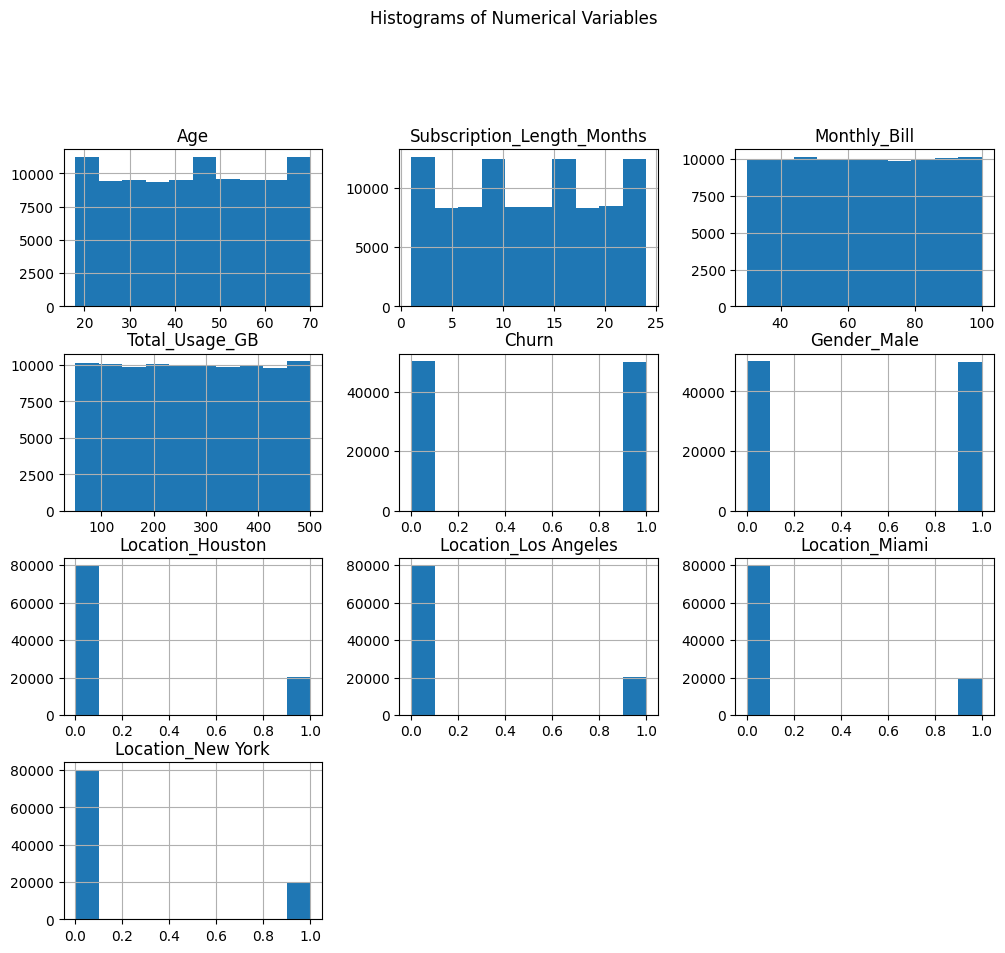

In [79]:
encoded_data.hist(figsize=(12, 10))
plt.suptitle('Histograms of Numerical Variables', y=1.02)
plt.show()

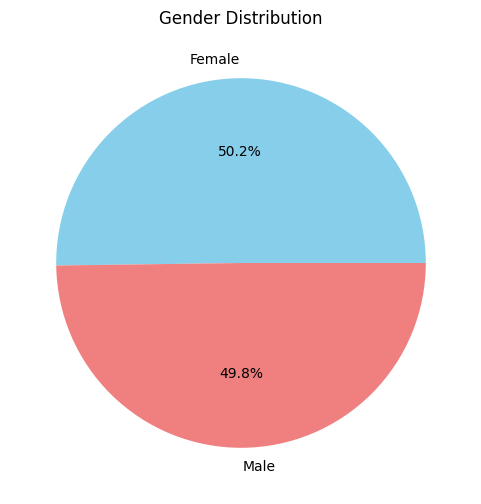

In [88]:
plt.figure(figsize=(6, 6))
df['Gender'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
plt.title('Gender Distribution')
plt.ylabel('')
plt.show()

The percentage of females is 50.2% and the percentage of males is 49.8%. This suggests that the gender distribution in this dataset is approximately equal.

**Splitting it into
training and testing sets**

---



In [133]:
from sklearn.model_selection import train_test_split

X = encoded_data.drop(['Churn', 'Name'], axis=1)
y = encoded_data['Churn']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


FEATURE ENGINEERING

**Generateing relevant features from the dataset that can help improve the model's prediction accuracy.**

In [134]:
# Calculate the average monthly usage
X_train['Avg_Monthly_Usage'] = X_train['Total_Usage_GB'] / X_train['Subscription_Length_Months']
X_test['Avg_Monthly_Usage'] = X_test['Total_Usage_GB'] / X_test['Subscription_Length_Months']

In [135]:
# Interaction between usage and bill
X_train['Usage_Bill_Interaction'] = X_train['Total_Usage_GB'] * X_train['Monthly_Bill']
X_test['Usage_Bill_Interaction'] = X_test['Total_Usage_GB'] * X_test['Monthly_Bill']

In [136]:
# Create binary columns for age categories
X_train['Age_Category_18-29'] = (X_train['Age'] >= 18) & (X_train['Age'] <= 29)
X_train['Age_Category_30-49'] = (X_train['Age'] >= 30) & (X_train['Age'] <= 49)
X_train['Age_Category_50-69'] = (X_train['Age'] >= 50) & (X_train['Age'] <= 69)
X_train['Age_Category_70+'] = X_train['Age'] >= 70

X_test['Age_Category_18-29'] = (X_test['Age'] >= 18) & (X_test['Age'] <= 29)
X_test['Age_Category_30-49'] = (X_test['Age'] >= 30) & (X_test['Age'] <= 49)
X_test['Age_Category_50-69'] = (X_test['Age'] >= 50) & (X_test['Age'] <= 69)
X_test['Age_Category_70+'] = X_test['Age'] >= 70

# Convert boolean values to integer (1 or 0)
age_category_columns = ['Age_Category_18-29', 'Age_Category_30-49', 'Age_Category_50-69', 'Age_Category_70+']
X_train[age_category_columns] = X_train[age_category_columns].astype(int)
X_test[age_category_columns] = X_test[age_category_columns].astype(int)



**MODEL BUILDING**(Without Normalization)

In [140]:



# Initialize a dictionary to store model performance metrics
model_metrics = {}

# Initialize and train different models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    model_metrics[model_name] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-score': f1}

# Print the performance metrics for each model
print('Before Scaling')
for model_name, metrics in model_metrics.items():
    print(f'{model_name}:')
    print(f'Accuracy: {metrics["Accuracy"]:.2f}')
    print(f'Precision: {metrics["Precision"]:.2f}')
    print(f'Recall: {metrics["Recall"]:.2f}')
    print(f'F1-score: {metrics["F1-score"]:.2f}')
    print('---')


Before Scaling
Logistic Regression:
Accuracy: 0.50
Precision: 0.49
Recall: 0.23
F1-score: 0.31
---
Random Forest:
Accuracy: 0.50
Precision: 0.50
Recall: 0.48
F1-score: 0.49
---


**MODEL BUILDING**(With Normalization)

In [141]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [168]:
model_metrics = {}

# Initialize and train different models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'RandomForestClassifier':RandomForestClassifier(),
    'GradientBoostingClassifier':GradientBoostingClassifier(),
    'SVM':SVC(),
    'Naive Bayes':GaussianNB(),
    'KNN':KNeighborsClassifier()
}

for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    model_metrics[model_name] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-score': f1}

# Print the performance metrics for each model
print('After Scaling:')
for model_name, metrics in model_metrics.items():
    print(f'{model_name}:')
    print(f'Accuracy: {metrics["Accuracy"]:.2f}')
    print(f'Precision: {metrics["Precision"]:.2f}')
    print(f'Recall: {metrics["Recall"]:.2f}')
    print(f'F1-score: {metrics["F1-score"]:.2f}')
    print('---')


After Scaling:
Logistic Regression:
Accuracy: 0.50
Precision: 0.50
Recall: 0.38
F1-score: 0.43
---
Random Forest:
Accuracy: 0.50
Precision: 0.50
Recall: 0.48
F1-score: 0.49
---
RandomForestClassifier:
Accuracy: 0.50
Precision: 0.50
Recall: 0.48
F1-score: 0.49
---
GradientBoostingClassifier:
Accuracy: 0.50
Precision: 0.50
Recall: 0.42
F1-score: 0.46
---
SVM:
Accuracy: 0.50
Precision: 0.50
Recall: 0.39
F1-score: 0.44
---
Naive Bayes:
Accuracy: 0.50
Precision: 0.50
Recall: 0.49
F1-score: 0.50
---
KNN:
Accuracy: 0.50
Precision: 0.49
Recall: 0.50
F1-score: 0.50
---


MODEL OPTIMIZATION

Cross Validation

In [170]:
from sklearn.model_selection import cross_val_score

# Define your model (e.g., RandomForestClassifier with default parameters)
model = RandomForestClassifier()

# Perform cross-validation (using 5-fold cross-validation)
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')

# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())


Cross-Validation Scores: [0.4984375 0.4955    0.4936875 0.50075   0.503875 ]
Mean CV Score: 0.49844999999999995


Applying NEURAL NETWORK Using Tensorflow and Keras

In [157]:
model = keras.Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Binary classification, so used sigmoid activation function


In [159]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [160]:
model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
2500/2500 [==============================] - 6s 2ms/step - loss: 0.6959 - accuracy: 0.4996
Epoch 2/10
2500/2500 [==============================] - 3s 1ms/step - loss: 0.6936 - accuracy: 0.5024
Epoch 3/10
2500/2500 [==============================] - 3s 1ms/step - loss: 0.6932 - accuracy: 0.5070
Epoch 4/10
2500/2500 [==============================] - 3s 1ms/step - loss: 0.6931 - accuracy: 0.5060
Epoch 5/10
2500/2500 [==============================] - 3s 1ms/step - loss: 0.6931 - accuracy: 0.5065
Epoch 6/10
2500/2500 [==============================] - 3s 1ms/step - loss: 0.6930 - accuracy: 0.5092
Epoch 7/10
2500/2500 [==============================] - 3s 1ms/step - loss: 0.6929 - accuracy: 0.5110
Epoch 8/10
2500/2500 [==============================] - 3s 1ms/step - loss: 0.6928 - accuracy: 0.5117
Epoch 9/10
2500/2500 [==============================] - 5s 2ms/step - loss: 0.6927 - accuracy: 0.5127
Epoch 10/10
2500/2500 [==============================] - 3s 1ms/step - loss: 0.692

In [161]:
y_pred = model.predict(X_test_scaled)
y_pred_binary = np.round(y_pred)
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy:.2f}")

625/625 [==============================] - 2s 2ms/step
Accuracy: 0.50
